# Interpolation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from math import cos, sin
from math import sqrt

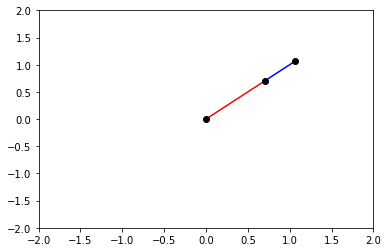

In [2]:
class TwoLinkArm:
    def __init__(self, joint_angles= [0, 0]):
        self.shoulder = np.array([0, 0])
        self.link_lengths = [1, 0.5]
        self.update_joints(joint_angles)
        
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.forward_kinematics()
        return [self.elbow, self.wrist]
        
    def forward_kinematics(self):
        theta0 = self.joint_angles[0]
        theta1 = self.joint_angles[1]
        l0 = self.link_lengths[0]
        l1 = self.link_lengths[1]
        self.elbow = self.shoulder + np.array([l0 * cos(theta0), l0 * sin(theta0)])
        self.wrist = self.elbow + np.array([l1 * cos(theta0 + theta1), l1 * sin(theta0 + theta1)])
        
    def inverse_kinematics(self, x, y):
        theta1 = np.pi - np.arccos((self.link_lengths[0]**2 + self.link_lengths[1]**2 - x**2 - y**2) / (2*self.link_lengths[0]*self.link_lengths[1]))
        theta0 = np.arctan2(y, x) - np.arccos((self.link_lengths[0]**2 + x**2 + y**2 - self.link_lengths[1]**2) / (2*self.link_lengths[0]*((x**2 + y**2)**0.5)))
        return [theta0, theta1]
        
    def plot(self):
        plt.axis([-2,2,-2,2])
        plt.plot([self.shoulder[0], self.elbow[0]], [self.shoulder[1], self.elbow[1]], 'r-')
        plt.plot([self.elbow[0], self.wrist[0]], [self.elbow[1], self.wrist[1]], 'b-')
        plt.plot(self.shoulder[0], self.shoulder[1], 'ko')
        plt.plot(self.elbow[0], self.elbow[1], 'ko')
        plt.plot(self.wrist[0], self.wrist[1], 'ko')
 

arm = TwoLinkArm([pi/4, 0])
arm.plot()

## Point-to-Point Interpolation

#### Asynchronous : 
Each joint reaches desired angle **at its maximum speed**.

#### Synchronized : 
Each joint reaches desired angle **simultaneously**.

Maximun joint speed:  0.087 rad
Desired joint angles:  [1.571 3.142]
Desired position:  [-0.   0.5]

 
Simulating time step


interactive(children=(IntSlider(value=24, description='sim_t', max=49), Output(layout=Layout(height='300px')))…

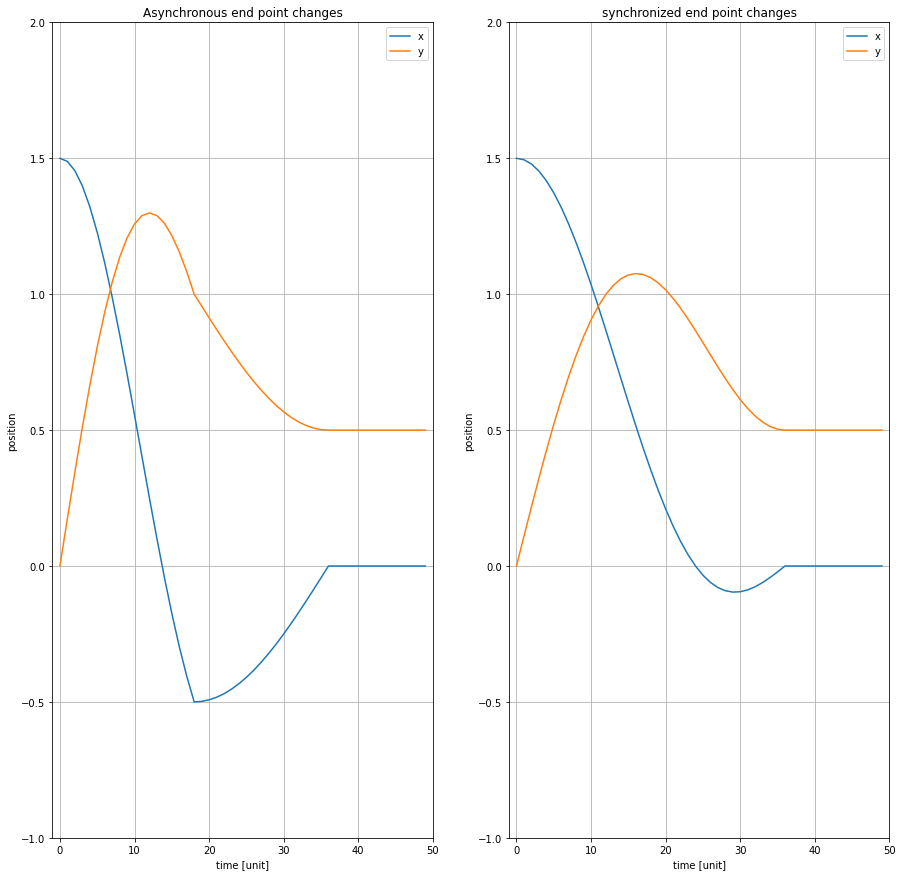

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.rcParams["figure.figsize"]=15,15

# Simulation time steps
t = 50
dt = np.arange(0, t)

# Assume joint0 and joint1 are able to rotate 30 degree per unit time
joint_max_rad = 5 / 180 * np.pi
print("Maximun joint speed: ", np.round(joint_max_rad, 3), "rad")

### Initialization
## Initialize async-p2p arm
current_theta = np.zeros((t,2))
arm_async = TwoLinkArm(current_theta[0])
current_position = np.zeros((t,2))

## Initialize sync-p2p arm
current_theta_sync = np.zeros((t,2))
arm_sync = TwoLinkArm(current_theta[0])
current_position_sync = np.zeros((t,2))

### Set desired goal (position or joint angle)
## Set desired position (x, y)
# desired_position = [-0.5, 0.9]
# desired_theta = arm.inverse_kinematics(desired_position[0], desired_position[1])

## Set desired joint angle (joint1, joint2)
desired_theta = np.array([pi/2, pi])
desired_position = arm.update_joints(desired_theta)
print("Desired joint angles: ", np.round(desired_theta, 3))
print("Desired position: ", np.round(desired_position[1], 3))



###Simulate arm movement
## create tmp variable
dif_theta = np.zeros((t,2))
dif_theta_sync = np.zeros((t,2))

## Pre-calculate joint speed for each joint to achieve sync
dif_theta_sync[0] = desired_theta - current_theta_sync[0]
sync_time_steps = np.around(np.max((dif_theta_sync[0]) / joint_max_rad))
sync_joint_speed = np.array(dif_theta_sync[0] / sync_time_steps)

## Simulate in timesteps
for i in range(t):
    ## Async
    # Update difference between goal and current angle
    dif_theta[i] = desired_theta - current_theta[i]
    # Limit angle change in maximum speed 
    dif_theta[i] = np.where(dif_theta[i] > joint_max_rad, joint_max_rad, dif_theta[i])
    if i < t-1:
        # Update current angle
        current_theta[i+1] = current_theta[i] + dif_theta[i] 
    # Forward kinematics, calculate current end position
    arm_async.update_joints(current_theta[i])
    current_position[i] = arm_async.wrist
    
    ## Sync
    # Update difference between goal and current angle
    dif_theta_sync[i] = desired_theta - current_theta_sync[i]
    # Limit angle change in pre-calculated speed 
    dif_theta_sync[i][0] = np.where(dif_theta_sync[i][0] > sync_joint_speed[0], sync_joint_speed[0], dif_theta_sync[i][0])
    dif_theta_sync[i][1] = np.where(dif_theta_sync[i][1] > sync_joint_speed[1], sync_joint_speed[1], dif_theta_sync[i][1])
    if i < t-1:
        # Update current angle
        current_theta_sync[i+1] = current_theta_sync[i] + dif_theta_sync[i] 
    # Forward kinematics, calculate current end position
    arm_sync.update_joints(current_theta_sync[i])
    current_position_sync[i] = arm_sync.wrist

# Plot async end point changes
ax = plt.subplot(121)
ax.set_xlim(-1, t); ax.set_ylim(-1, 2);
ax.set_xlabel('time [unit]')
ax.set_ylabel('position')
ax.plot(dt, current_position[:])
ax.set_aspect('auto')
ax.legend(['x', 'y'])
ax.set_title('Asynchronous end point changes')
ax.grid()

# Plot sync end point changes
bx = plt.subplot(122)
bx.set_xlim(-1, t); bx.set_ylim(-1, 2);
bx.set_xlabel('time [unit]')
bx.set_ylabel('position')
bx.plot(dt, current_position_sync[:])
bx.set_aspect('auto')
bx.legend(['x', 'y'])
bx.set_title('synchronized end point changes')
bx.grid()

# Interactive time simulation plot
def iterpolation(sim_t):
    # Update arm according to sim_t
    arm_async.update_joints(current_theta[sim_t])
    arm_sync.update_joints(current_theta_sync[sim_t])
    
    # Plot async arm
    async_plt = plt.subplot(121)
    async_plt.axis([-2,2,-0.5,2])
    async_plt.set_aspect('equal')
    async_plt.set_title('Asynchronous')
    async_plt.plot([arm_async.shoulder[0], arm_async.elbow[0]], [arm_async.shoulder[1], arm_async.elbow[1]], 'r-')
    async_plt.plot([arm_async.elbow[0], arm_async.wrist[0]], [arm_async.elbow[1], arm_async.wrist[1]], 'b-')
    async_plt.plot(arm_async.shoulder[0], arm_async.shoulder[1], 'ko')
    async_plt.plot(arm_async.elbow[0], arm_async.elbow[1], 'ko')
    async_plt.plot(arm_async.wrist[0], arm_async.wrist[1], 'ko')
    async_plt.text(arm_async.wrist[0], arm_async.wrist[1], np.round(arm_async.wrist, 2))
    async_plt.grid()
    
    # Plot sync arm
    sync_plt = plt.subplot(122)
    sync_plt.axis([-2,2,-0.5,2])
    sync_plt.set_aspect('equal')
    sync_plt.set_title('Synchronized')
    sync_plt.plot([arm_sync.shoulder[0], arm_sync.elbow[0]], [arm_sync.shoulder[1], arm_sync.elbow[1]], 'r-')
    sync_plt.plot([arm_sync.elbow[0], arm_sync.wrist[0]], [arm_sync.elbow[1], arm_sync.wrist[1]], 'b-')
    sync_plt.plot(arm_sync.shoulder[0], arm_sync.shoulder[1], 'ko')
    sync_plt.plot(arm_sync.elbow[0], arm_sync.elbow[1], 'ko')
    sync_plt.plot(arm_sync.wrist[0], arm_sync.wrist[1], 'ko')
    sync_plt.text(arm_sync.wrist[0], arm_sync.wrist[1], np.round(arm_sync.wrist, 2))
    sync_plt.grid()

# Interation function 
print("\n \nSimulating time step")
interactive_plot = interactive(iterpolation, sim_t=(0, t-1, 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot


## Continuous-Path (Straight line) Interpolation


In [4]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.rcParams["figure.figsize"]=5,5

# Simulation time steps
t = 50
dt = np.arange(0, t)

# Initialize an arm
current_theta = np.zeros((t,2))
arm = TwoLinkArm(current_theta[0])
current_position = np.zeros((t,2))
current_position[0] = arm.wrist

# Set desired goal (position)
desired_position = [-0.5, 0.9]
desired_theta = arm.inverse_kinematics(desired_position[0], desired_position[1])
print("Desired position: ", np.round(desired_position, 3))


###Simulate arm movement
## create tmp variable
distance = np.zeros((t,2))

## Pre-calculate change distance for each timestep
total_distance = desired_position - current_position[0]
distance_change_time_steps = total_distance / (t-1)

## Simulate in timesteps
for i in range(t):
    # Update difference between goal and current position
    distance[i] = desired_position - current_position[i]
    if i < t-1:
        # Update position
        current_position[i+1] = current_position[i] + distance_change_time_steps
    # inverse kinematics, calculate current angle
    current_theta[i] = arm.inverse_kinematics(current_position[i][0], current_position[i][1])

# Interactive time simulation plot
def iterpolation(sim_t):
    # Update arm according to sim_t
    arm.update_joints(current_theta[sim_t])
    arm.plot()
    plt.plot([current_position[0][0], desired_position[0]], [current_position[0][1], desired_position[1]], '-oy')
    plt.text(arm.wrist[0], arm.wrist[1], np.round(arm.wrist, 2))


# Interation function 
print("\n \nSimulating time step")
interactive_plot = interactive(iterpolation, sim_t=(0, t-1, 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot


Desired position:  [-0.5  0.9]

 
Simulating time step


interactive(children=(IntSlider(value=24, description='sim_t', max=49), Output(layout=Layout(height='300px')))…

# Speed Profile: Shock-free and Jerk-limited

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from math import cos, sin
from math import sqrt

### Given parameters: 
***a_max***

***v_max***

***s_total***

In [6]:
# Set parameters
a_max = 2 # m/(s**2)
v_max = 2 # m/s
s_total = 5 # m

# acceleration time can be determined from a_max and v_max
t_acc = 1.5 * (v_max / a_max)

## Phase 1: acceleration profile

Gien a_max and t_acc, we are able to calcultae the interpolation params.

**Assume acceleration function a(t) = At<sup>2</sup> + Bt + C**

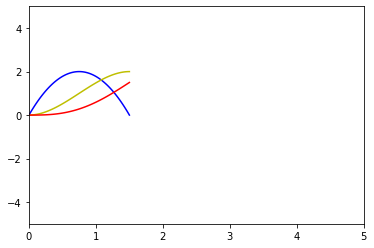

In [7]:
t = np.linspace(0, t_acc, 100)

a_1 = (-4*a_max) * (t**2) / (t_acc**2)  + (4*a_max) * t / (t_acc)
v_1 = (-4*a_max) * (t**3)/ (3*(t_acc**2)) + (4*a_max) * (t**2) / (2*t_acc)
s_1 = (2*a_max*(t**3)*t_acc - a_max*(t**4)) / (3*(t_acc**2))

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
ax.plot(t, a_1, 'b')
ax.plot(t, v_1, 'y')
ax.plot(t, s_1, 'r')

## Phase 2: Plateau state

t_plateau:  1.0


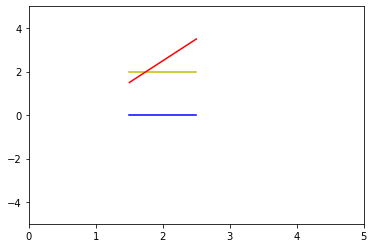

In [8]:
t_plateau = (s_total - 2*s_1[-1])/v_max
print("t_plateau: ", t_plateau)

t = np.linspace(t_acc,t_plateau + t_acc, 100)
a_2 = 0*t
v_2 = v_max * np.ones((t.shape))
s_2 = s_1[-1] + v_max * (t - t_acc)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
ax.plot(t, a_2, 'b')
ax.plot(t, v_2, 'y')
ax.plot(t, s_2, 'r')

## Phase 3: Braking Phase

Since the equation is too complicated. I use the inverted phase1 as workaround.

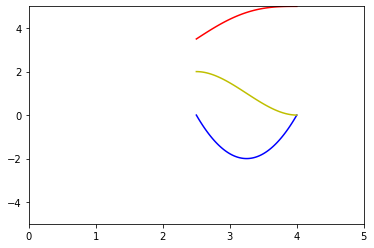

In [9]:
# t = np.linspace(t_acc + t_plateau, t_acc + t_plateau + t_acc, 100)
t = np.linspace(0, t_acc, 100)


# a_3 = (4*a_max*(t_plateau**2))/(t_acc**2) + (12*a_max*t_plateau)/t_acc - (8*a_max*t*t_plateau)/(t_acc**2) - (12*a_max*t)/t_acc + (4*a_max*(t**2))/(t_acc**2) + 8*a_max
# v_3 = -(4*a_max*(t_plateau**3))/(3*t_acc**2) - (6*a_max*(t_plateau**2))/t_acc + (4*a_max*t*(t_plateau**2))/(t_acc**2) + (12*a_max*t*t_plateau)/t_acc - (4*a_max*(t**2)*t_plateau)/(t_acc**2) - 8*a_max*t_plateau - 8*a_max*t_acc/3 - 6*a_max*(t**2)/t_acc + 4*a_max*(t**3)/(3*(t_acc**2)) + 8*a_max*t

a_3 = -(-4*a_max) * (t**2) / (t_acc**2)  - (4*a_max) * t / (t_acc)
v_3 = v_2[-1] - ((-4*a_max) * (t**3)/ (3*(t_acc**2)) + (4*a_max) * (t**2) / (2*t_acc))
s_3 = s_2[-1] + v_2[-1]*t - ((-a_max) * (t**4)/ (3*(t_acc**2)) + (4*a_max) * (t**3) / (6*t_acc))

t = np.linspace(t_acc + t_plateau, t_acc + t_plateau + t_acc, 100)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
ax.plot(t, a_3, 'b')
ax.plot(t, v_3, 'y')
ax.plot(t, s_3, 'r')

## Overall profile

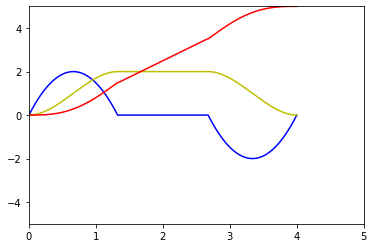

In [10]:
t = np.linspace(0, 2*t_acc+t_plateau, 300)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0, 5); ax.set_ylim(-5, 5);
a = np.concatenate((a_1, a_2, a_3))
v = np.concatenate((v_1, v_2, v_3))
s = np.concatenate((s_1, s_2, s_3))
ax.plot(t, a, 'b')
ax.plot(t, v, 'y')
ax.plot(t, s, 'r')